In [1]:
import statistics
from collections import defaultdict
%reload_ext autoreload

%autoreload 2
import numpy as np
from models import lstm
import torch
from collections import defaultdict
import scipy.stats as st
import matplotlib.pyplot as plt


In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 

NPY_INPUT_DIR = '/Users/ianmagnusson/IITUDND/data/extracted_features/combined_NLP/irma/'

In [3]:
def plot_cis(binNames, binRatios, priors):
    '''
    Requires a list of group str outputs and bin ratios from get_accuracy_graph - one for each run
    Collect results of both get_accuracy_plot return values -- names and binRatios-- in an array to run this.
    '''
    priors = np.array(priors[0])
    binVals = defaultdict(list)
    for run in range(len(binRatios)):
        for bin in range(len(binRatios[run])):
            binVals[bin+1].append(binRatios[run][bin]) # append the ratio (accuracy) of the bin to list
    cis = []
    means = []
    keys = []
    binLabels = [name for name in binNames[0]]
    for bin in binVals: # Calculate mean and CI for each bin
        keys.append(bin)
        mean = np.mean(binVals[bin])
        means.append(mean)
        standard = statistics.stdev(binVals[bin])
        cis.append(standard)
    plt.figure()  # initiate accuracy plot
    plt.plot(keys, means, label="Mean Accuracy by Bin")  # plot accuracy by bin
    plt.plot(keys, priors, label="Naive Accuracy")
    plt.errorbar(keys, means, yerr=cis)
    plt.xticks(keys, binLabels)
    plt.suptitle('Test classification accuracy rate by user history length (CI .95)')
    plt.xlabel('User history length (lowest to highest), sorted into bins (ascending order)')
    plt.ylabel('Accuracy rate')
    plt.show()
    return



In [4]:
def test_100(X_train, y_train, X_test, y_test):
    running_acc = 0.0
    running_auc = 0.0
    graph_results = []
    bin_names = []
    priors_list = []
    
    
    for i in range(2):
        model = lstm.LSTM(input_dim = 400, hidden_dim = 84, num_layers = 1, bidirectional = True,
                  learning_rate = 0.012299062522117071, momentum = 0.48958379148316544, decay_factor = 0.8731070777804946)
        model.learn(X_train, y_train, epochs=1)
        
        # evaluate
        running_acc += model.get_accuracy(X_test, y_test)
        running_auc += model.get_auc(X_test, y_test)
        bins, accRates, priors = model.get_accuracy_graph(X_test, y_test)
        bin_names.append(bins)
        graph_results.append(accRates)
        priors_list.append(priors)
    #model.plot_CIs(bin_names, graph_results)
    
    return running_acc/100, running_auc/100, bin_names, graph_results, priors_list

In [5]:
# load data from files

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))

In [ ]:
# format npz objects as lists of arrays again
X_tfidf_train = [ torch.Tensor(X_seq_tfidf_train[file]) for file in X_seq_tfidf_train.files]
X_tfidf_test = [ torch.Tensor(X_seq_tfidf_test[file]) for file in X_seq_tfidf_test.files]

X_glove_train = [ torch.Tensor(X_seq_glove_train[file]) for file in X_seq_glove_train.files]
X_glove_test = [ torch.Tensor(X_seq_glove_test[file]) for file in X_seq_glove_test.files]

In [ ]:
# build lists with features concatenated

from sklearn.preprocessing import StandardScaler

X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


In [8]:
%%capture
# mutes output for this cell

acc, auc, bin_names, graph_results, priors_list = test_100(X_train,y_train,X_test,y_test)

0.0164480198019802
0.01562954227020271


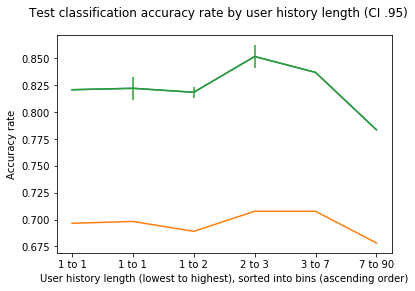

In [9]:
print(acc)
print(auc)
plot_cis(bin_names, graph_results, priors_list)

In [ ]:
import pickle

with open('bin_names.p', 'wb') as fout:
    pickle.dump(bin_names, fout)
    
with open('graph_results.p', 'wb') as fout:
    pickle.dump(graph_results, fout)
    

In [ ]:
"""
import pickle
with open('bin_names.p', 'rb') as fin:
    bin_names = pickle.load(fin)
with open('graph_results.p', 'rb') as fin:
    graph_results = pickle.load(fin)
"""

